<a href="https://colab.research.google.com/github/rahuliyer/ai_experiments/blob/main/Leopard_or_Cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Leopard, Cheetah, or Jaguar?

This is a notebook to detect whether a picture is that of a leopard, cheetah, or a jaguar.

## Install libraries

In [ ]:
#hide
!pip install -Uqq google-colab fastai duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 30.2 MB/s eta 0:00:00


## Prepare the data set

First search for images using the Duck Duck Go library

In [ ]:
from duckduckgo_search import DDGS

In [ ]:
def search_images(term, max_images=30):
  with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term, max_results=max_images)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]

        return image_urls

Download the images and check if they are ok

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

cheetah_image_urls = search_images("cheetah photos", max_images=1)
cheetah_image_urls[0]


'https://www.rd.com/wp-content/uploads/2019/11/cheetah-1.jpg'

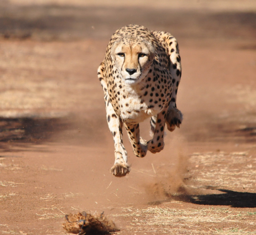

In [ ]:
filename = 'cheetah.jpg'
download_url(cheetah_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [ ]:
leopard_image_urls = search_images("leopard photos", max_images=1)
leopard_image_urls[0]


'http://www.pixelstalk.net/wp-content/uploads/2016/05/Animal-Leopard-HD-Wallpaper-High-Resolution.jpg'

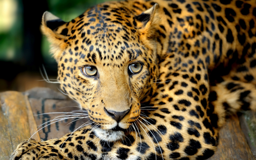

In [ ]:
filename = 'leopard.jpg'
download_url(leopard_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [ ]:
jaguar_image_urls = search_images("jaguar photos", max_images=1)
jaguar_image_urls[0]

'https://cdn.wallpapersafari.com/96/61/jcFUY5.jpeg'

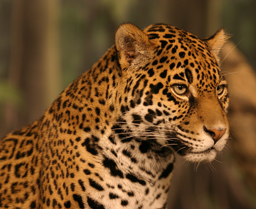

In [ ]:
filename = 'jaguar.jpg'
download_url(jaguar_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

Create a function to download images with sleeps so we don't hammer the server

In [ ]:
def download_images_with_interval(urls, dest, batch_size=10, sleep_interval=10):
  index = 0
  while index < len(urls):
    urls_to_download = urls[index:index + batch_size]
    download_images(dest, urls=urls_to_download)
    sleep(sleep_interval)
    index += batch_size


In [ ]:
from time import sleep
from pathlib import Path

searches = ['leopard', 'cheetah', 'jaguar']

search_urls = {}

for search in searches:
  search_urls[search] = search_images(f"{search} images", max_images=100)


Download the images into the following tree structure:
```
- big_cats/
    - leopard/
    - cheetah/
    - jaguar
```



In [ ]:
data_dir = Path('big_cats')

max_before_sleep = 10
sleep_interval = 10

for search in search_urls:
  dest_dir = f"{data_dir}/{search}"
  Path(dest_dir).mkdir(exist_ok=True, parents=True)

  download_images_with_interval(search_urls[search], dest_dir)


Clean images that did not download properly

In [ ]:
failed = verify_images(get_image_files(data_dir))
failed.map(Path.unlink)

(#0) []

## Training

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


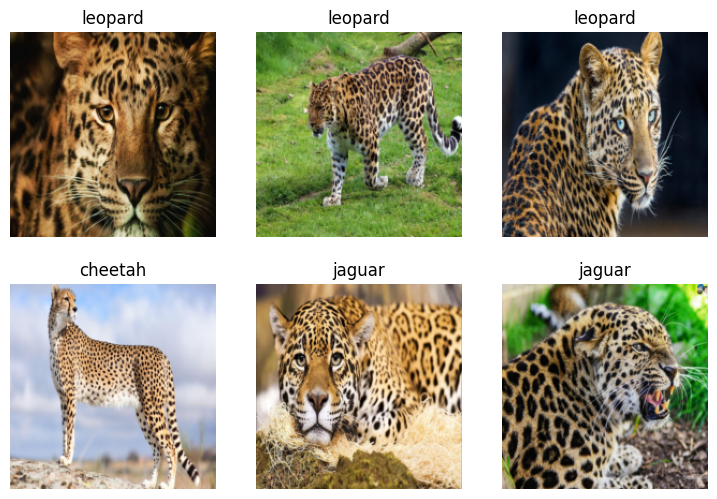

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(data_dir, bs=128)

dls.show_batch(max_n=6)

In [ ]:
save_model_cb = SaveModelCallback(monitor='valid_loss')

learn = vision_learner(dls, resnet18, metrics=error_rate, cbs=save_model_cb)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


Better model found at epoch 0 with valid_loss value: 1.9512443542480469.


Better model found at epoch 0 with valid_loss value: 1.6846683025360107.
Better model found at epoch 1 with valid_loss value: 1.3894741535186768.
Better model found at epoch 2 with valid_loss value: 1.155138611793518.
Better model found at epoch 3 with valid_loss value: 0.9757751822471619.
Better model found at epoch 4 with valid_loss value: 0.9103828072547913.
Better model found at epoch 5 with valid_loss value: 0.8640217185020447.
Better model found at epoch 6 with valid_loss value: 0.8248187303543091.
Better model found at epoch 7 with valid_loss value: 0.7963324189186096.
Better model found at epoch 8 with valid_loss value: 0.7631741762161255.
Better model found at epoch 9 with valid_loss value: 0.7170356512069702.


In [ ]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([9.7853e-04, 1.3421e-02, 9.8560e-01]))

In [ ]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9998e-01, 1.5918e-05, 5.0961e-06]))

In [ ]:
learn.predict(PILImage.create('jaguar.jpg'))

('jaguar', tensor(1), tensor([2.9897e-05, 9.9948e-01, 4.8787e-04]))

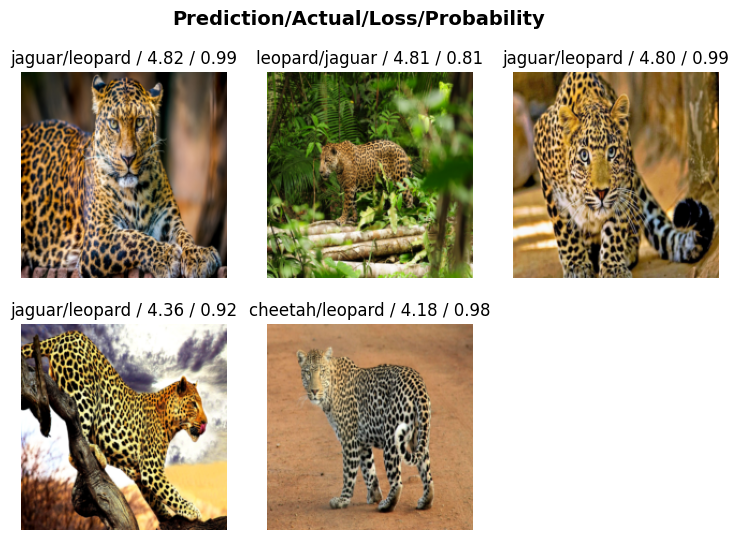

In [ ]:
Interpretation.from_learner(learn).plot_top_losses(5)

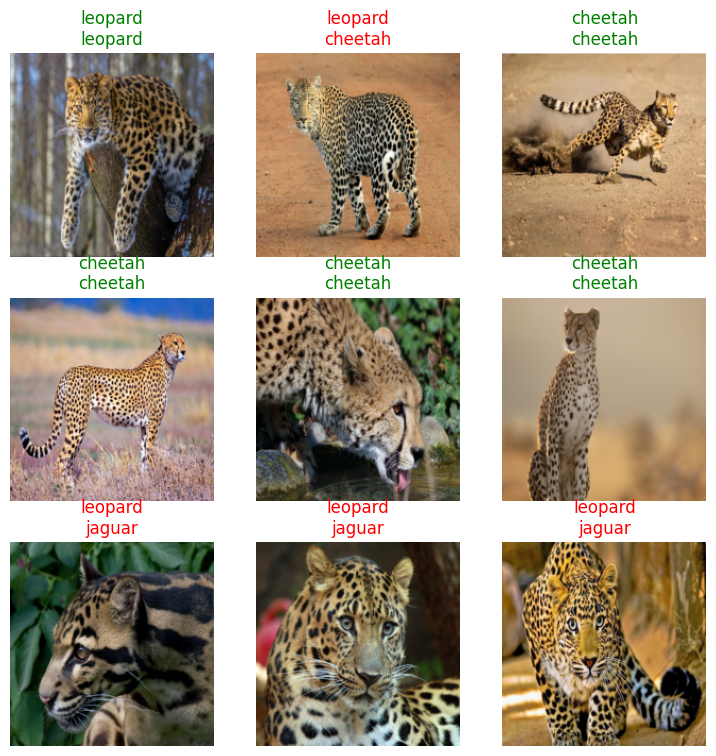

In [ ]:
learn.show_results()

Now let's try a bigger model

In [ ]:
save_model_cb = SaveModelCallback(monitor='valid_loss')

learn = vision_learner(dls, resnet50, metrics=error_rate, cbs=save_model_cb)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


Better model found at epoch 0 with valid_loss value: 1.1479016542434692.


Better model found at epoch 0 with valid_loss value: 0.9259647130966187.
Better model found at epoch 1 with valid_loss value: 0.6723650097846985.
Better model found at epoch 2 with valid_loss value: 0.47279685735702515.
Better model found at epoch 3 with valid_loss value: 0.38223403692245483.
Better model found at epoch 4 with valid_loss value: 0.3310709595680237.
Better model found at epoch 5 with valid_loss value: 0.3004457354545593.
Better model found at epoch 6 with valid_loss value: 0.2899269163608551.


In [ ]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([0.0209, 0.2742, 0.7049]))

In [ ]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9963e-01, 8.9855e-05, 2.7798e-04]))

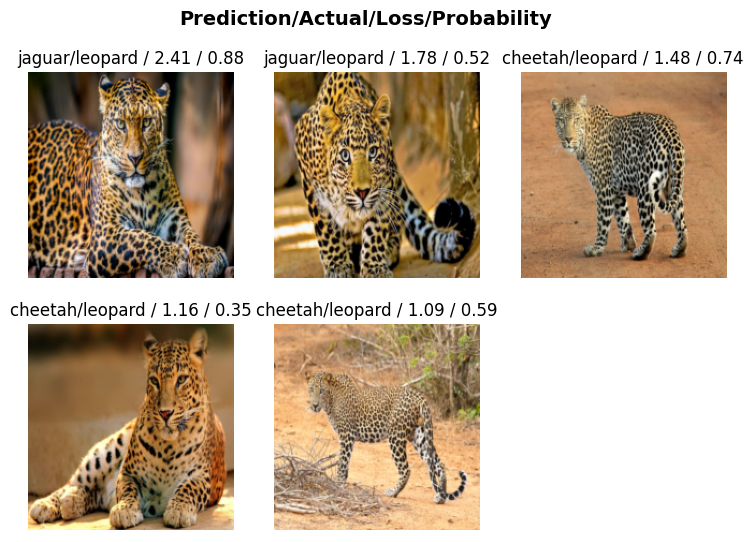

In [ ]:
Interpretation.from_learner(learn).plot_top_losses(5)

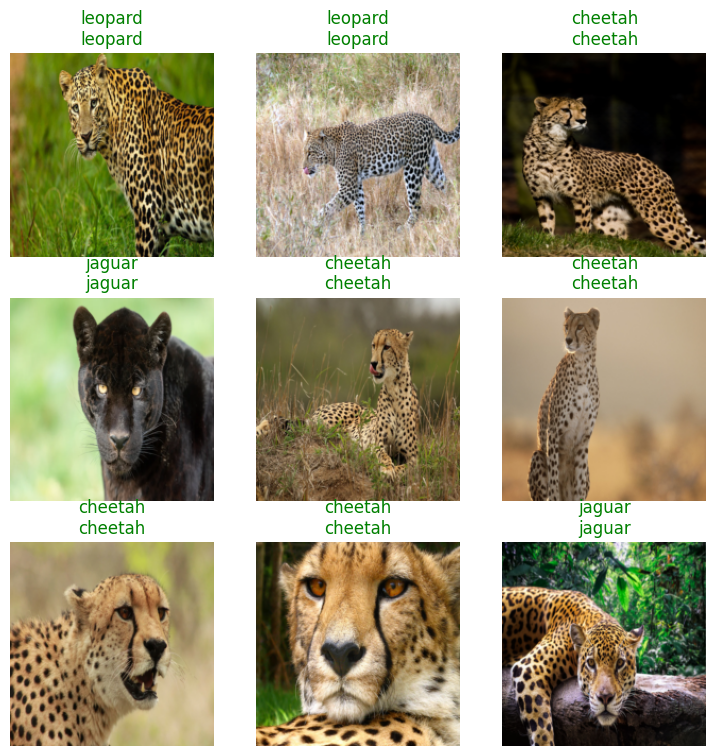

In [ ]:
learn.show_results()